In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.model.mlm.pet_for_text_classification import train as train_model
import warnings
warnings.filterwarnings("ignore")

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "PET"
dataset_name = "RAFT-WIKI-QA"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Loading dataset

In [69]:
dataset = load_dataset(
    "wiki_qa", 
    cache_dir= "/Data/pedro.silva"
)

In [70]:
train_dataset = dataset['train']

In [71]:
classes = np.unique(train_dataset['label'], return_counts=True)
classes

(array([0, 1]), array([19320,  1040]))

In [72]:
classes_names = ["wrong", "correct"]

In [73]:
.7
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    if isinstance(dataset, pd.DataFrame):
        df = dataset

    else:
        df = dataset.to_pandas()
        
    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = df.query(f"label == {label}")


    
    train_data = {
        'label': [],
        'text': [],
        'question': [],
        'answer': []
    }

    validation_data = {
        "label" : [],
        "text": [],
        'question': [],
        'answer': []
    }

    class_proportion = df['label'].value_counts()/len(df)

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])

        if isinstance(train_size, int):
            size = round(class_proportion[label] * train_size)
            
        else:
            size = int(train_size * n)

        train_data['text'] += df.query(f"label == {label}")\
            [0:size]\
            ['text']\
            .to_list()
            
        train_data['question'] += df.query(f"label == {label}")\
            [0:size]\
            ['question']\
            .to_list()
            
        train_data['answer'] += df.query(f"label == {label}")\
            [0:size]\
            ['answer']\
            .to_list()
        
        train_data['label'] += [label]*size
        
        validation_data['text'] +=df.query(f"label == {label}")\
            [size:]\
            ['text']\
            .to_list()
        
        validation_data['question'] +=df.query(f"label == {label}")\
            [size:]\
            ['question']\
            .to_list()
        
        validation_data['answer'] +=df.query(f"label == {label}")\
            [size:]\
            ['answer']\
            .to_list()
        
        validation_data['label'] += [label]* (n-size)

    return train_data, validation_data

In [74]:
train_df = train_dataset.to_pandas()

In [75]:
train_df['text'] = train_df['question']+train_df['answer']
# train_df = train_df.sample(frac=1)

In [76]:
train_df['question'].str.endswith('?')

0         True
1         True
2         True
3         True
4         True
         ...  
20355    False
20356    False
20357    False
20358    False
20359    False
Name: question, Length: 20360, dtype: bool

In [77]:
train_df

,question_id,question,document_title,answer,label,text
0,Q1,how are glacier caves formed?,Glacier cave,A partly submerged glacier cave on Perito More...,0,how are glacier caves formed?A partly submerge...
1,Q1,how are glacier caves formed?,Glacier cave,The ice facade is approximately 60 m high,0,how are glacier caves formed?The ice facade is...
2,Q1,how are glacier caves formed?,Glacier cave,Ice formations in the Titlis glacier cave,0,how are glacier caves formed?Ice formations in...
3,Q1,how are glacier caves formed?,Glacier cave,A glacier cave is a cave formed within the ice...,1,how are glacier caves formed?A glacier cave is...
4,Q1,how are glacier caves formed?,Glacier cave,"Glacier caves are often called ice caves , but...",0,how are glacier caves formed?Glacier caves are...
...,...,...,...,...,...,...
20355,Q3043,what is section eight housing,Section 8 (housing),A tenant who leaves a subsidized project will ...,0,what is section eight housingA tenant who leav...
20356,Q3043,what is section eight housing,Section 8 (housing),The United States Department of Housing and Ur...,0,what is section eight housingThe United States...
20357,Q3044,what is the main type of restaurant,Category:Types of restaurants,Restaurants categorized by type and informatio...,0,what is the main type of restaurantRestaurants...
20358,Q3046,what is us dollar worth based on,History of the United States dollar,U.S. Federal Reserve notes in the mid-1990s,0,what is us dollar worth based onU.S. Federal R...


## Few shot learning study - 50 shots

In [78]:
classes = np.unique(train_df['label'], return_counts=True)
train_validation, test_df = stratified_train_test_split(
    train_df,
    classes,
    train_size = 50
)

In [79]:
train, val  = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    30
)

In [80]:
val = pd.DataFrame(val).to_dict('list')
test = pd.DataFrame(test_df).sample(n = 5000).to_dict('list')

In [81]:
def pattern1(
    question: str, 
    answer : str,
    tokenizer : AutoTokenizer
):
    return f"Is {answer} a valid answer for {question} {tokenizer.mask_token}"

In [82]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",
                                          cache_dir = "/Data/pedro.silva")
class_names = ["wrong", "correct"]

idx2class = {i : v for i,v in enumerate(class_names)}

class2idx = {v:i for i, v in enumerate(class_names)}


verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [83]:
verbalizer

{0: 3308, 1: 6149}

In [84]:

def preprocess(question : List[str], answer : List[str], labels : List[int]):

    processed_text = []
    processed_labels = []
    for idx in range(len(question)):
        label = idx2class[labels[idx]]
        # text_ = text[idx]
        
        q = question[idx]
        a = answer[idx]

        processed_text.append(pattern1(q,a, tokenizer))
        processed_labels.append(label)

    return processed_text, processed_labels

In [85]:
train_text, train_labels = preprocess(train['question'], train['answer'], train['label'])
val_text, val_labels = preprocess(val['question'], val['answer'], val['label'])
test_text, test_labels = preprocess(test['question'], test['answer'], test['label'])

In [86]:
class PETDatasetForClassification(Dataset):
    def __init__(
        self, 
        processed_text : List[str], 
        labels : List[int],
        tokenizer : AutoTokenizer,
        device : str = "cuda"
    ) -> None:
        super().__init__()

        self.tokens = tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        self.encoded_labels = deepcopy(self.tokens['input_ids'])
        
        self.encoded_labels[self.encoded_labels != tokenizer.mask_token_id] = -100

        for idx, sentence in tqdm(enumerate(self.encoded_labels)):
            sentence[sentence == tokenizer.mask_token_id] = tokenizer.vocab[labels[idx].lower()]

        self.inputs : Dict[str, torch.Tensor] = self.tokens
        self.inputs['labels'] = self.encoded_labels

        for k,v in self.inputs.items():
            self.inputs[k] = v.to(device)

    def __getitem__(self, index):
        d : Dict = dict()
        for key in self.inputs.keys():
            d[key] = self.inputs[key][index]

        return d
    
    def __len__(self):
        return self.tokens['input_ids'].shape[0]

In [87]:
train_dataset = PETDatasetForClassification(
    train_text,
    train_labels,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    val_text,
    val_labels,
    tokenizer
)

test_dataset = PETDatasetForClassification(
    test_text,
    test_labels,
    tokenizer
)

30it [00:00, 187.02it/s]
20it [00:00, 196.69it/s]
5000it [00:24, 201.65it/s]


In [88]:
train_dataloader = DataLoader(train_dataset, shuffle= True)
val_dataloader =DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [89]:
_, class_counts = np.unique(
    train['label'],
    return_counts=True,
)

alpha = len(train['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val['label'],
    return_counts=True,
)
alpha_val = len(val['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test['label'],
    return_counts=True,
)
alpha_test = len(test['label'])/class_counts_test
alpha, alpha_val, alpha_test

(array([ 1.07142857, 15.        ]),
 array([ 1.05263158, 20.        ]),
 array([ 1.05108262, 20.57613169]))

In [90]:
from src.utils import FocalLoss

In [91]:
classes

(array([0, 1]), array([19320,  1040]))

In [92]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased",
                                             cache_dir = "/Data/pedro.silva").to(device)
history, confusion_matrix, best_model = train_model(
    train_dataloader,
    val_dataloader,
    num_classes = len(class_names),
    model = model,
    verbalizer = verbalizer,
    tokenizer=tokenizer,
    alpha = 1e-6,
    lr=1e-5,
    evaluation_fn= binary_f1_score,
    loss_fn=FocalLoss(alpha, gamma=1),
    n_epochs=20
)

Epoch 19
f1-score : 1.0
tensor([[19,  0],
        [ 0,  1]], device='cuda:0')


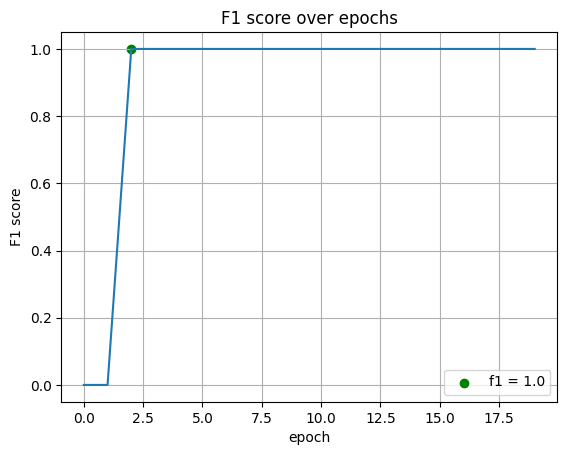

In [93]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-WIKI-QA - PET')

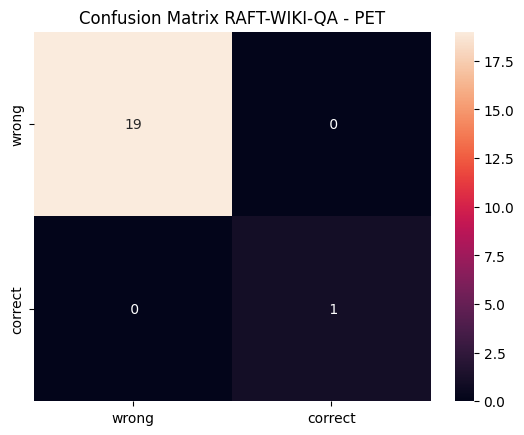

In [94]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## Test results

In [95]:
from src.model.mlm.pet_for_text_classification import get_y_true

In [96]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = binary_f1_score(
        y_pred_test,
        y_true_test,
        # num_classes= len(classes[0])
    )

100%|██████████| 5000/5000 [00:42<00:00, 117.22it/s]


In [97]:
f1

tensor(0.0078, device='cuda:0')

Text(0.5, 1.0, 'Confusion Matrix RAFT-WIKI-QA - PET')

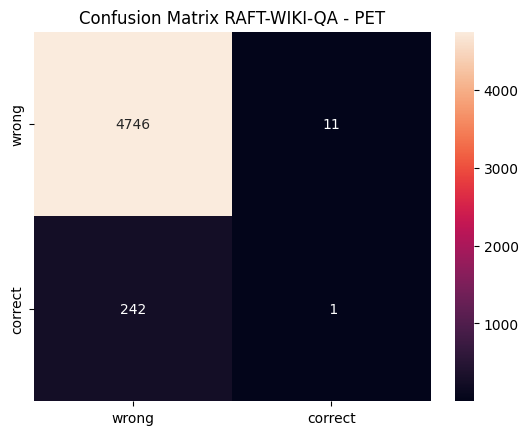

In [98]:
conf_matrix = multiclass_confusion_matrix(
    y_pred_test.to(torch.int64),
    y_true_test.to(torch.int64),
    num_classes= len(classes[0])
)

df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## General approach - 500 shots

In [ ]:
classes = np.unique(dataset['train']['label'], return_counts=True)
n_shots = 500
train_validation, test_df = stratified_train_test_split(
    dataset['train'],
    classes,
    train_size = n_shots
)

In [ ]:
train_df, val_df = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    300
)

In [ ]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [ ]:
def pattern1(text: str, tokenizer : AutoTokenizer):
    return f"{text} The previous text refers to anger, joy, optimism or sadness ? {tokenizer.mask_token}"

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",
                                          cache_dir = "/Data/pedro.silva")
class_names = ["anger", "joy", "optimism", "sadness"]

idx2class = {i : v for i,v in enumerate(class_names)}

class2idx = {v:i for i, v in enumerate(class_names)}


verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [ ]:
verbalizer

{0: 4963, 1: 6569, 2: 27451, 3: 12039}

In [ ]:

def preprocess(text : List[str], labels : List[int]):

    processed_text = []
    processed_labels = []
    for idx in range(len(text)):
        label = idx2class[labels[idx]]
        text_ = text[idx]

        processed_text.append(pattern1(text_, tokenizer))
        processed_labels.append(label)

    return processed_text, processed_labels

In [ ]:
train_text, train_labels = preprocess(train_df['text'], train_df['label'])
val_text, val_labels = preprocess(val_df['text'], val_df['label'])
test_text, test_labels = preprocess(test_df['text'], test_df['label'])

In [ ]:
class PETDatasetForClassification(Dataset):
    def __init__(
        self, 
        processed_text : List[str], 
        labels : List[int],
        tokenizer : AutoTokenizer,
        device : str = "cuda"
    ) -> None:
        super().__init__()

        self.tokens = tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        self.encoded_labels = deepcopy(self.tokens['input_ids'])
        
        self.encoded_labels[self.encoded_labels != tokenizer.mask_token_id] = -100

        for idx, sentence in tqdm(enumerate(self.encoded_labels)):
            sentence[sentence == tokenizer.mask_token_id] = tokenizer.vocab[labels[idx].lower()]

        self.inputs : Dict[str, torch.Tensor] = self.tokens
        self.inputs['labels'] = self.encoded_labels

        for k,v in self.inputs.items():
            self.inputs[k] = v.to(device)

    def __getitem__(self, index):
        d : Dict = dict()
        for key in self.inputs.keys():
            d[key] = self.inputs[key][index]

        return d
    
    def __len__(self):
        return self.tokens['input_ids'].shape[0]

In [ ]:
train_dataset = PETDatasetForClassification(
    train_text,
    train_labels,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    val_text,
    val_labels,
    tokenizer
)

test_dataset = PETDatasetForClassification(
    test_text,
    test_labels,
    tokenizer
)

300it [00:01, 189.02it/s]
200it [00:01, 191.15it/s]
1000it [00:05, 190.07it/s]


In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle= True)
val_dataloader =DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [ ]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val_df['label'],
    return_counts=True,
)
alpha_val = len(val_df['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test_df['label'],
    return_counts=True,
)
alpha_test = len(test_df['label'])/class_counts_test
alpha, alpha_val, alpha_test

(array([ 2.3255814 ,  4.61538462, 11.11111111,  3.79746835]),
 array([ 2.3255814 ,  4.54545455, 11.11111111,  3.84615385]),
 array([ 2.28310502,  4.60829493, 11.9047619 ,  3.83141762]))

In [ ]:
from src.utils import FocalLoss

In [ ]:
classes

(array([0, 1, 2, 3]), array([1400,  708,  294,  855]))

In [ ]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased",
                                             cache_dir = "/Data/pedro.silva").to(device)
history, confusion_matrix, best_model = train(
    train_dataloader,
    val_dataloader,
    num_classes = len(class_names),
    model = model,
    verbalizer = verbalizer,
    tokenizer=tokenizer,
    alpha = 1e-5,
    evaluation_fn= multiclass_f1_score,
    loss_fn=FocalLoss(alpha, gamma=1),
    n_epochs=20
)

Epoch 19
f1-score : 0.7449999451637268
tensor([[68,  7,  1, 10],
        [ 3, 37,  0,  4],
        [ 7,  4,  7,  0],
        [ 8,  6,  1, 37]], device='cuda:0')


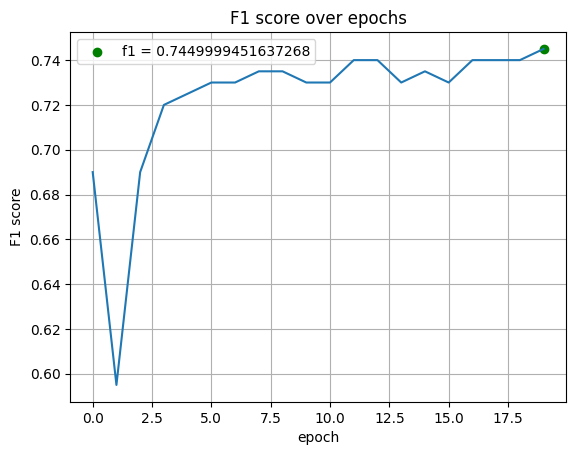

In [ ]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-TWITTER-EMOTION - PET')

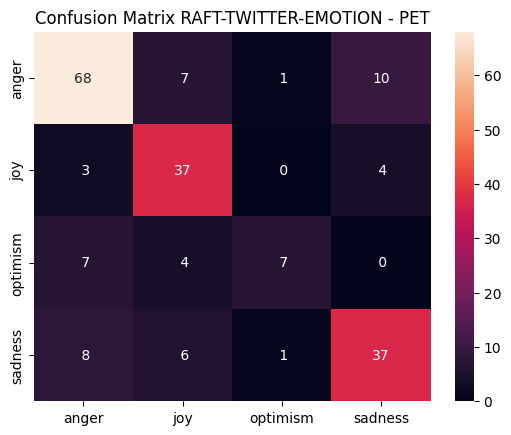

In [ ]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## Test results

In [ ]:
from src.model.mlm.pet_for_text_classification import get_y_true

In [ ]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = multiclass_f1_score(
        y_pred_test,
        y_true_test,
        num_classes= len(classes[0])
    )

100%|██████████| 1000/1000 [00:08<00:00, 118.28it/s]


In [ ]:
f1

tensor(0.7320, device='cuda:0')